# `DSML Workshop 12` - Decision Trees

In this workshop we take a deep-dive on tree-based methods (and ensembles thereof) commonly used in a myriad of classification and regression problems.

We will cover the following: 
1. Decision Trees for classification (breast cancer example)
1. Decision Trees for regression (peak electrical power example)
1. Ensemble methods (XGBoost, random forest)


In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

# Decision Trees for classification: classifying breast cancer cells

In [2]:
cancer_df = pd.read_csv("breast_cancer.csv", index_col="id")

In [3]:
cancer_df.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


To abstract from the relatively high-dimensionality of the breats cancer datset let us confine our analysis to a two-dimensional feature vector consiting of `area_mean` and `concave points_mean` for now.

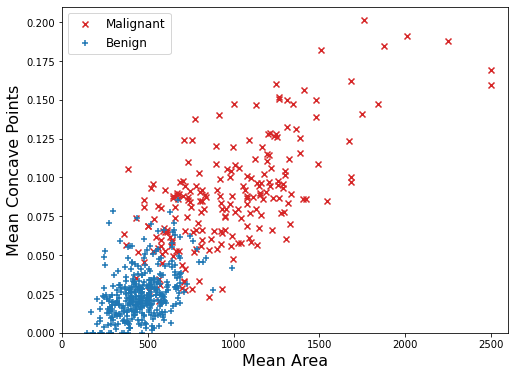

In [4]:
def plot_cells():
    plt.figure(figsize=(8,6))
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area",fontsize=16)
    plt.ylabel("Mean Concave Points",fontsize=16)
    plt.legend(['Malignant','Benign'],fontsize=12)
    
plot_cells()

We define X and Y vectors correspondingly:

In [5]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

Y  = np.where(Y=="M", int(1), Y) 
Y  = np.where(Y=="B", int(0), Y) 
Y = Y.astype('int')

Note that we do not need to normalize, as Decision Trees do not work based on distances across features!

We then specify and fit a simple `DecisionTreeClassifier`, which is available via `sklearn`

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree_classifier = DecisionTreeClassifier(max_depth=2,criterion='gini') # we set gini as our impurity measure
tree_classifier.fit(X, Y)

DecisionTreeClassifier(max_depth=2)

The decision estimator has an attribute called tree_  which stores the entire tree structure and allows access to low level attributes. The binary tree_ attribute is represented as a number of parallel arrays. The i-th element of each array holds information about the node `i`. Node 0 is the tree's root.

In [7]:
structure = tree_classifier.tree_

Among those arrays, we have:

   - left_child, id of the left child of the node
   - right_child, id of the right child of the node
   - feature, feature used for splitting the node
   - threshold, threshold value at the node
   - impurity, the impurity (i.e., the value of the splitting criterion) at the node
   - etc.

In [8]:
# assign various tree attributes

n_nodes = structure.node_count
n_leaves = structure.n_leaves
children_left = structure.children_left
children_right = structure.children_right
feature = structure.feature
threshold = structure.threshold
impurity = structure.impurity

In [9]:
print("Num nodes: \t",n_nodes)
print("Num leaves: \t",n_leaves)

Num nodes: 	 7
Num leaves: 	 4


In [10]:
print("left children per node: ", children_left)
print("right children per node: ", children_right)
print("Decision feature at node: ", feature)
print("Threshold of feature at node", threshold)
print("Impurity at node: ", impurity)

left children per node:  [ 1  2 -1 -1  5 -1 -1]
right children per node:  [ 4  3 -1 -1  6 -1 -1]
Decision feature at node:  [ 1  0 -2 -2  0 -2 -2]
Threshold of feature at node [ 5.14199995e-02  6.96250000e+02 -2.00000000e+00 -2.00000000e+00
  6.56500000e+02 -2.00000000e+00 -2.00000000e+00]
Impurity at node:  [0.46753006 0.10804509 0.05290204 0.47530864 0.22214876 0.48661157
 0.05876951]


Next let's retrieve the decision path of a selected sample. 

The `decision_path` method allows to retrieve the node indicator functions. A non zero element of indicator matrix at the position (i, j) indicates that the sample i goes through the node j.

In [11]:
node_indicator = tree_classifier.decision_path(X)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = tree_classifier.apply(X)

# Now, it's possible to get the tests that were used to predict a sample or

sample_id = np.random.randint(0,len(X))

# index node, i.e. which nodes does the sample pass
node_index = node_indicator.indices[node_indicator.indptr[sample_id]: #indptr maps the elements of data and indices to the rows of the sparse matrix
                                    node_indicator.indptr[sample_id + 1]]  #indptr maps the elements of data and indices to the rows of the sparse matrix

In [12]:
# sample with sample_id passes through the following nodes 
# node 0 is the root
# final node is the leave
print(sample_id)
node_index

128


array([0, 4, 6], dtype=int32)

In [13]:
print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    
    # skip leave node
    if leave_id[sample_id] == node_id:
        continue
    
    # 
    if (X[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

Rules used to predict sample 128: 
decision id node 0 : (X[128, 1] (= 0.08534) > 0.051419999450445175)
decision id node 4 : (X[128, 0] (= 674.5) > 656.5)


### Plot decision tree

Arguably this is a little abstract and not too intuitive. Therefore, we will visualize the underlying tree and try to relate it back to the tree structure above.

We will visualize the decision tree using `graphviz`. If you haven't done so already please go ahead and install `graphviz` by sequentially executing the two following commands via the terminal:
- `conda install -c anaconda graphviz `
- ` conda install -c conda-forge python-graphviz`

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

def plot_class_tree_sklearn(tree_depth):

    model = DecisionTreeClassifier(max_depth=tree_depth,
                                  criterion='gini') # we set gini as our impurity measure
    model.fit(X, Y)
    
    dot_data = export_graphviz(model,
                               feature_names=['area_mean','concave points_mean'],
                              class_names = ["Begning","Malignant"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

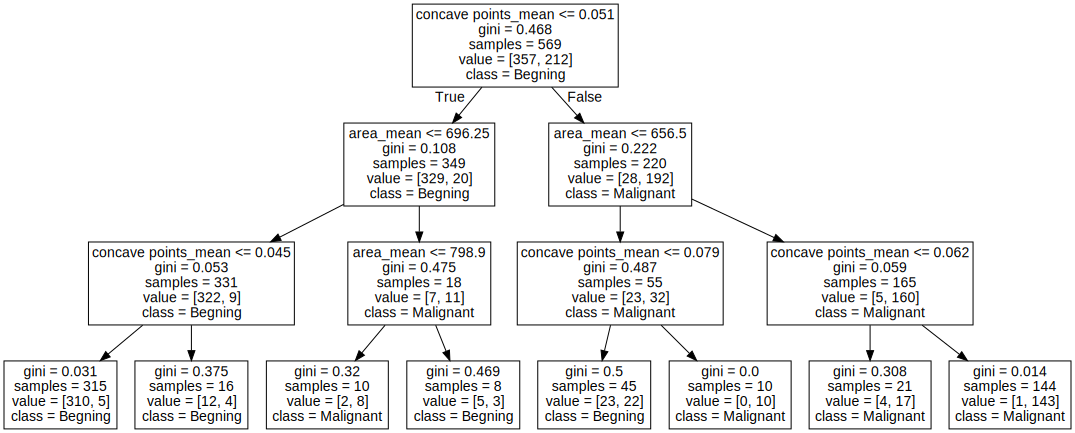

In [15]:
plot_class_tree_sklearn(3)

In the decision tree each node is represented by a box. For each node the following information is provided:
- decision feature and threshold
- impurity
- number of samples
- number of samples per class
- class (i.e., majority vote)

We can, thus, easily relate this back to the tree attributes we computed above. A selection is below:

In [16]:
print("Num nodes: \t",n_nodes)
print("Num leaves: \t",n_leaves)
print("Feature at node", feature) # -2 indicates no feature/threshold, i.e. a leaf
print("Threshold of feature at node", threshold)
print("Impurity at node: ", impurity)

Num nodes: 	 7
Num leaves: 	 4
Feature at node [ 1  0 -2 -2  0 -2 -2]
Threshold of feature at node [ 5.14199995e-02  6.96250000e+02 -2.00000000e+00 -2.00000000e+00
  6.56500000e+02 -2.00000000e+00 -2.00000000e+00]
Impurity at node:  [0.46753006 0.10804509 0.05290204 0.47530864 0.22214876 0.48661157
 0.05876951]


### Plot decision surfaces

As we have seen in the lecture another intuitive representation of decision trees is the use of decsion surfaces. These can be related back directly to the decision tree. For ease of use a plotting routine has been prepared that combines fitting and plotting into a single routine and allows for easy adjustment of tree-depth.

In [17]:
def plot_class_surface(tree_depth):
    
    # specify and fit decision tree classifier
    from sklearn.tree import DecisionTreeClassifier, export_graphviz # we also call the garphviz module for later visualization
    model = DecisionTreeClassifier(max_depth=tree_depth,
                                  criterion='gini') # we set entropy as our impurity measure
    model.fit(X, Y)
    
    # get tree attributes
    
    attributes = model.tree_
    
    # define range per feature
    x_range = [0,2600] # i.e. mean area
    y_range = [0, 0.21] # i.e mean conc. points
    plt.figure(figsize=(8,6))
    
    
    # plot classifcation regions
    grid=1000
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))


    zz = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = zz.reshape(xx.shape)
    cs = plt.contourf(xx, yy,zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')
    
    # plot datapoints
    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area",fontsize=16)
    plt.ylabel("Mean Concave Points",fontsize=16)
    plt.legend([s1,s2],['Malignant','Benign'],fontsize=12)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    
    plt.show()
    
    #plt.savefig("Breast_Cancer_Decision_Surface_{}depth.pdf".format(tree_depth))

number of nodes:  15
number of leafs:  8


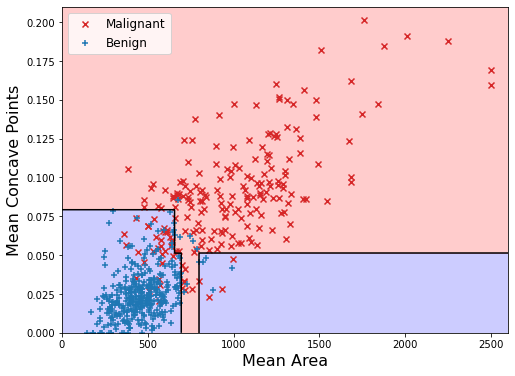

In [18]:
plot_class_surface(3)

### Controlling overfitting in Decision Trees

**Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.**

This can easyily be seen by increasin tree depth to unreasonable values:

number of nodes:  103
number of leafs:  52


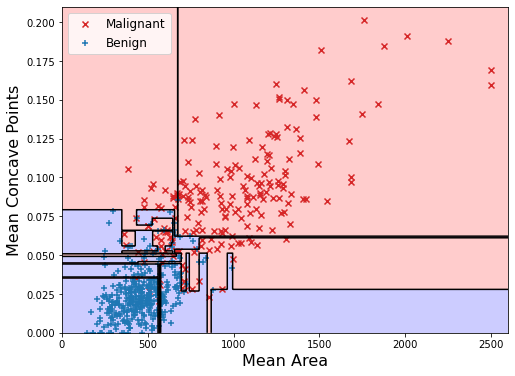

In [19]:
plot_class_surface(15)

### Optimizing tree predictive performance

- **max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).
- **min_samples_leaf**: By specifying a minimum number of samples per leaf (>>1); overfitting can be controlled for
- **ccp_alpha**: Cost Complexity (CCP) alpha paramter determines the size of the penalty


In this example we will look at the **cost complexity** as an effective measure in avoiding overfitting. The cost complexity of a tree (CCP(T)) is defined as 

\begin{equation}
CCP(T) = ERR(Z) + \alpha L(T)
\end{equation}

To get an idea of what values of $\alpha$ could be appropriate, `scikit-learn` provides `DecisionTreeClassifier.cost_complexity_pruning_path` that returns the effective alphas (i.e. those that will achieve the next step in complexity reduction) and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [20]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

# fit decision tree (without limit on max_depth, i.e. tree will grow fully if alpha is set to 0)
tree_classifier = DecisionTreeClassifier(random_state=0, 
                                         criterion="gini")

# compute cost_complexity_pruning_path 
path = tree_classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

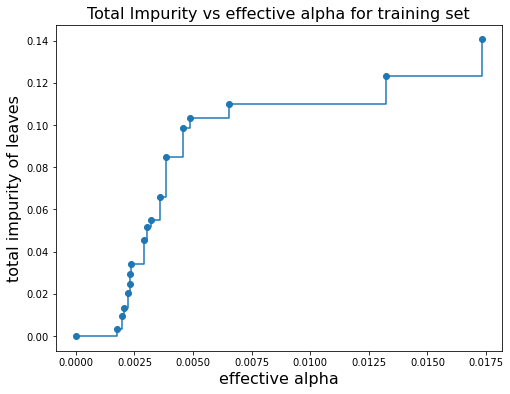

In [21]:
#plot cost_complexity_pruning_path

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  # we remove the last alpha as this corresponds to a tree with only the root node
ax.set_xlabel("effective alpha",fontsize=16)
ax.set_ylabel("total impurity of leaves",fontsize=16)
ax.set_title("Total Impurity vs effective alpha for training set",fontsize=16)

plt.savefig("Determining_Alpha.pdf")

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [22]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.32729844193277774


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

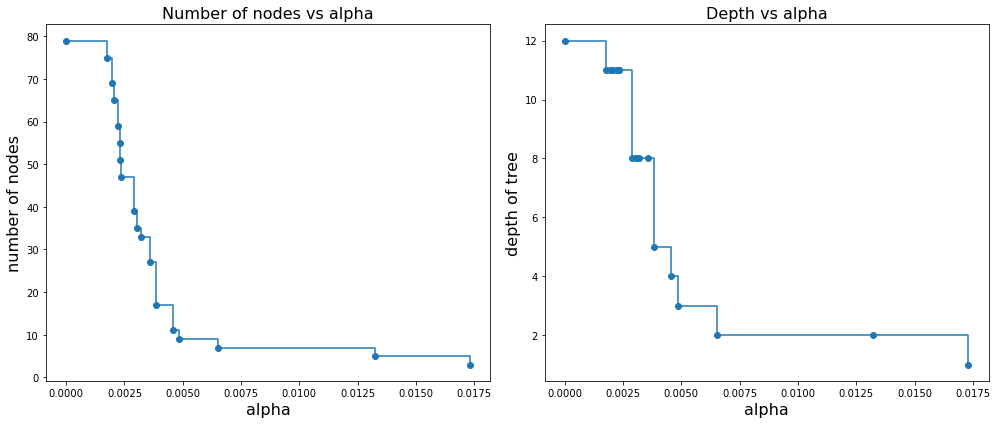

In [23]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha",fontsize=16)
ax[0].set_ylabel("number of nodes",fontsize=16)
ax[0].set_title("Number of nodes vs alpha",fontsize=16)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha",fontsize=16)
ax[1].set_ylabel("depth of tree",fontsize=16)
ax[1].set_title("Depth vs alpha",fontsize=16)
fig.tight_layout()

#plt.savefig("Pruning_effect.pdf")

In [24]:
len(ccp_alphas)

18

**Exercise**: Implement a grid search over the identified effective alphas to determine where predictive performance is maximized. Report the validation error (i.e., perform a 2-way split into training and validation set) for this setting.

Need to iterate over all indentified alphas

In [25]:
ccp_alphas

array([0.        , 0.00176056, 0.00195618, 0.00205399, 0.00223564,
       0.00229283, 0.00230624, 0.00234045, 0.00289975, 0.00304859,
       0.0031951 , 0.00358596, 0.00383565, 0.00457548, 0.00485534,
       0.00652311, 0.01323716, 0.01731205])

In [26]:
### YOUR CODE HERE


In [27]:
# Plot your results here

# Decision Trees for regression: predicting peak electrical power

We continue with our electric power example from last week which we retieved from PJM from the following link [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition)). The files we are loading are the raw files we downloaded from this source. The final input data for our code is `Pittsburgh_load_data.csv`.

In [28]:
df = pd.read_csv("Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df["Month"] = df["Date"].apply(lambda x: x.month)
df.head(2)

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month
0,2013-01-01,1.598524,1.859947,0.001599,38.368031,0.0,-1.68,1
1,2013-01-02,1.809347,2.054215,0.001809,43.428194,-3.9,-6.58,1


In [29]:
Xp = df["High_temp"].values
Yp = df["MAX"].values

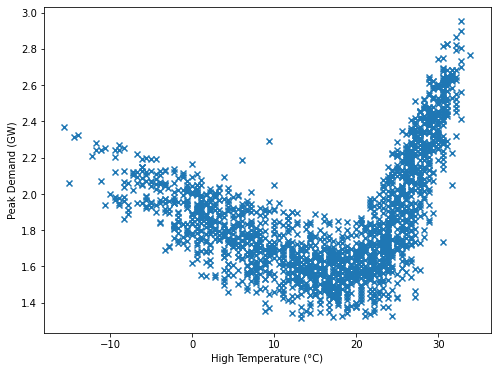

In [30]:
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

We will unse the `DecisionTreeRegressor` class in `scikitlearn`to fit and plot a decision tree regressor.

In [31]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,criterion="squared_error")
    Tree_reg.fit(Xp.reshape((-1,1)), Yp) 
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("High Temperature (°C)", fontsize=16)
    plt.ylabel("Peak Demand (GW)", fontsize=16)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    
    #plt.savefig("Peak_Power_Regression_Lines_{}depth.pdf".format(tree_depth))

number of nodes:  175
number of leafs:  88


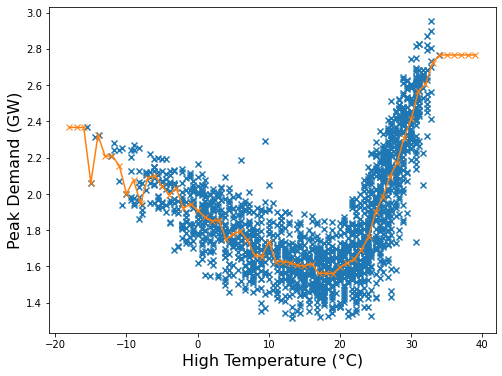

In [32]:
plot_tree_regression_line(50)

In [33]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(Xp.reshape((-1,1)), Yp) 
    
    dot_data = export_graphviz(model,
                              feature_names=["High_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

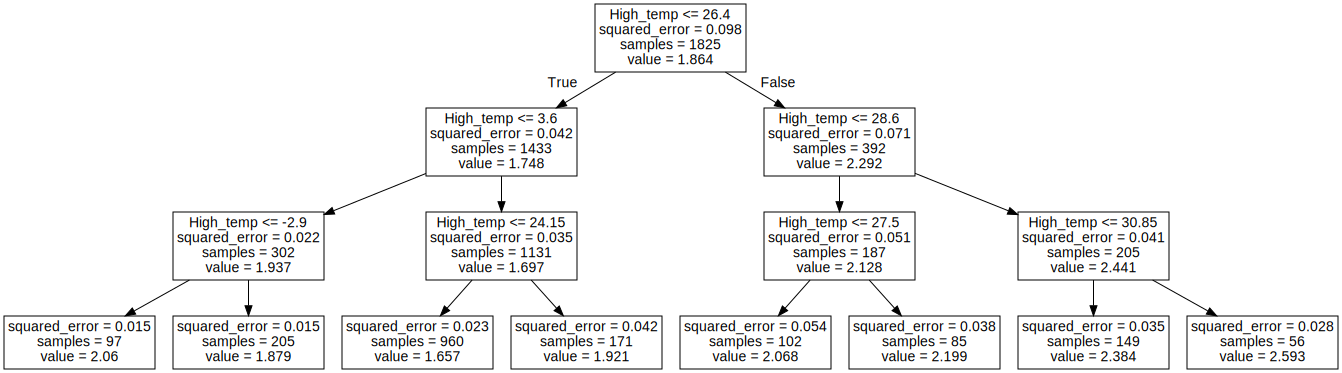

In [34]:
plot_regression_tree_sklearn(3)

# Ensemble Methods

In predictive modeling, “risk” is equivalent to variation (i.e. variance) in prediction error. Ensemble methods are targeted at reducing variance, thus increasing predictive power.
The core idea is that by combining the outcomes of individual models, e.g., by taking an average, variance may be reduced. Thus, using an average of two or more predictions can potentially lead to smaller error variance, and therefore better predictive power.

We will not discuss ensemble methods in detail here, but will limit our discussion to a brief discussion of two very popular tree-based ensemble methods. These are:

- XGBoost (a type a boosting method): see [here](https://xgboost.readthedocs.io/en/latest/)
- RandomForest: see [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

### XGBoost

XGBoost is an ensemple method that uses **boosting**. While XGBoost is not included in sklearn, there is a very well developed API that can be installed by executing the following command:
- `conda install -c conda-forge xgboost`

Once you have completed the installation you are good to go. Let us fit a v. simple classifier to the breastcancer dataset.

In [35]:
# train test split on breast cancer dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [36]:
# sepcify and fit model
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(booster="gbtree")
xgb_classifier.fit(X_train,y_train)

[12:25:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniconda/base/envs/neural-net/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniconda/base/envs/neural-net/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test,xgb_classifier.predict(X_test))

array([[81,  8],
       [ 5, 49]])

In [38]:
accuracy_score(y_test,xgb_classifier.predict(X_test))

0.9090909090909091

Obviously, there is likely room for improvement as you grid search some of the hyperparameters. However, by just taking the default setting, we already achieve an accuracy score that is comparable to that of the grid-searched decision tree above

### Random Forest

Random Forests is a selection of n trees which are trained in parallel. Predictions are made by averaging the outputs across these n trees. Random Forest are most often combined with **bagging**, i.e. different boostrap samples of the training data are used to train the individual trees.

In [39]:
from sklearn.ensemble import RandomForestClassifier

# sepcify and fit model

rf_classifier = RandomForestClassifier(n_estimators=100, 
                                       bootstrap=True, random_state=42) # we select boostrapp, i.e. we use bagging
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_test,rf_classifier.predict(X_test))

array([[80,  9],
       [ 3, 51]])

In [41]:
accuracy_score(y_test,rf_classifier.predict(X_test))

0.916083916083916

Again, just by taking the default setting, we obtain very good results that are comparable to those of the fully grid-searched decision tree.

__End of Workshop Exercise: Ensemble Methods in a regression setting__
Implement Ensemble Methods for predicting peak electricity demand in Pittburgh. For now, neglect the need for running grid searches but go with the defualt parameters of the algorithms as implemented in scikit learn. Review test performance and compare against the results from earlier workshops that used other paramteric prediction methods such as polynomial regression.

In [42]:
#### YOUR CODE HERE









---

---